<a href="https://colab.research.google.com/github/DrAlexSanz/nlp-demystified/blob/main/Fake_news_detection_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
import spacy
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from google.colab import drive

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Import data
Easier to download from kaggle and upload to my drive in this case

In [ ]:
raw_train = pd.read_csv("/content/drive/MyDrive/Datasets/fake_news/train.csv")
raw_test = pd.read_csv("/content/drive/MyDrive/Datasets/fake_news/test.csv") # Test dataset is to send to kaggle originally. I don't need this here.
raw_test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


### See if the dataset is balanced

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fda5d90cca0>]],
      dtype=object)

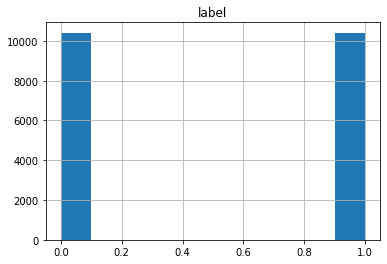

In [ ]:
raw_train.hist(column = "label")
# 1 is fake/unreliable. 0 is ok news.

### See if I can find a writer that always writes good/fake news.
* That admin guy is dangerous!

In [ ]:
# Start with fakes
fakes = raw_train[raw_train["label"] == 1]
fakes_text = fakes["text"].reset_index()
fakes = fakes[["id", "author"]]
authors = fakes.groupby(by = "author").agg("nunique")
authors.reset_index(inplace = True)
authors = authors.sort_values(by = "id", ascending = False)
authors.head()


,author,id
1710,admin,193
1213,Pakalert,86
526,Eddy Lavine,85
1474,Starkman,84
634,Gillian,82


In [ ]:
# Now do good news
good = raw_train[raw_train["label"] == 0]
good_text = good["text"].reset_index()
good = good[["id", "author"]]
authors = good.groupby(by = "author").agg("nunique")
authors.reset_index(inplace = True)
authors = authors.sort_values(by = "id", ascending = False)
authors.head()

,author,id
1732,Pam Key,242
949,Jerome Hudson,166
387,Charlie Spiering,141
997,John Hayward,140
1156,Katherine Rodriguez,124


In [ ]:
good_text.head()

,index,text
0,1,Ever get the feeling your life circles the rou...
1,5,"In these trying times, Jackie Mason is the Voi..."
2,7,"PARIS — France chose an idealistic, traditi..."
3,8,Donald J. Trump is scheduled to make a highly ...
4,9,A week before Michael T. Flynn resigned as nat...


### Let's have a quick look at the top words for good/fake news in case there is something obvious

In [ ]:
good_text.head()

,index,text
0,1,Ever get the feeling your life circles the rou...
1,5,"In these trying times, Jackie Mason is the Voi..."
2,7,"PARIS — France chose an idealistic, traditi..."
3,8,Donald J. Trump is scheduled to make a highly ...
4,9,A week before Michael T. Flynn resigned as nat...


In [ ]:
good_list = good_text["text"].str.split().to_list()

In [ ]:
good_list[:2] # This is a list of lists

In [ ]:
flat_good_list = [item for sublist in good_list for item in sublist] # Flatten it

In [ ]:
flat_good_list[:50]

In [ ]:
len(flat_good_list)

9130137

In [ ]:
def plot_top_words(flat_list, title):
    word_count_dict = dict(Counter(flat_list))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]

    plt.figure(figsize = (15,15))
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

    return

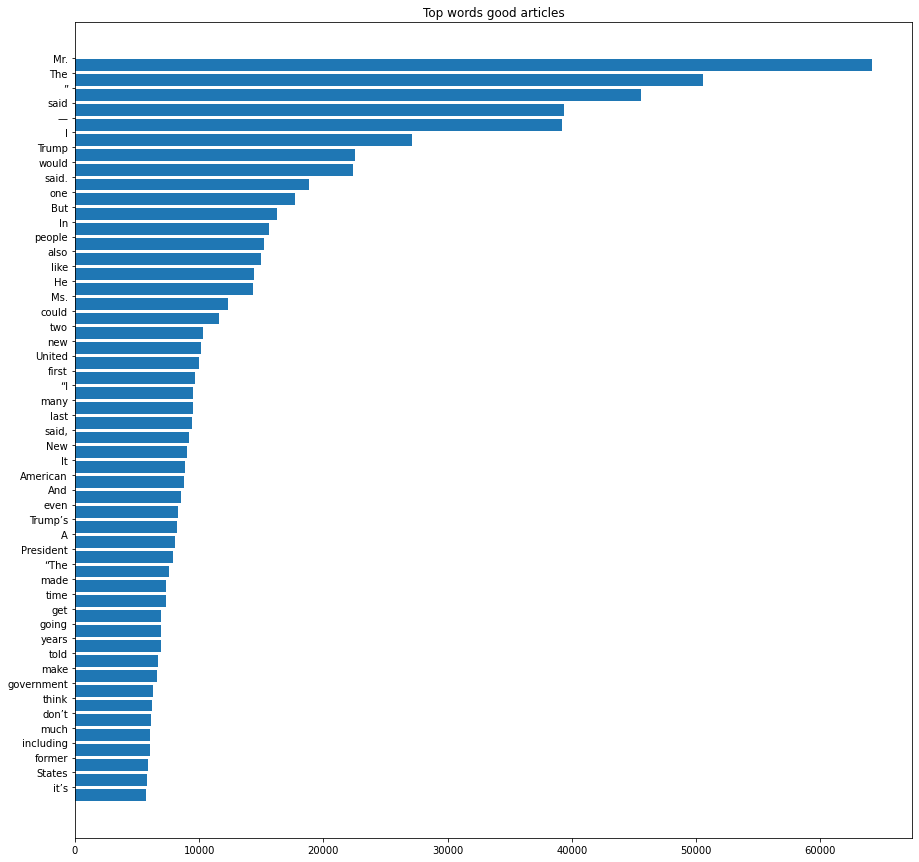

In [ ]:
plot_top_words(flat_list = flat_good_list, title = "Top words good articles")

# Note that the tokenization is not great but it can be improved

In [ ]:
nlp = spacy.load("en_core_web_sm")

def spacy_tokenizer(doc):
    transformed = [t.text for t in nlp(doc) if \
                not t.is_space and \
                not t.is_stop and \
                t.is_alpha]

    return transformed


In [ ]:
# It's 9M tokens. Uncomment at your own risk
#flat_good_list = [spacy_tokenizer(tok) for tok in flat_good_list]

In [ ]:
fakes_list = fakes_text["text"].astype(str).str.split().to_list()
flat_fakes_list = [item for sublist in fakes_list for item in sublist] # Flatten it
len(flat_fakes_list)

6654659

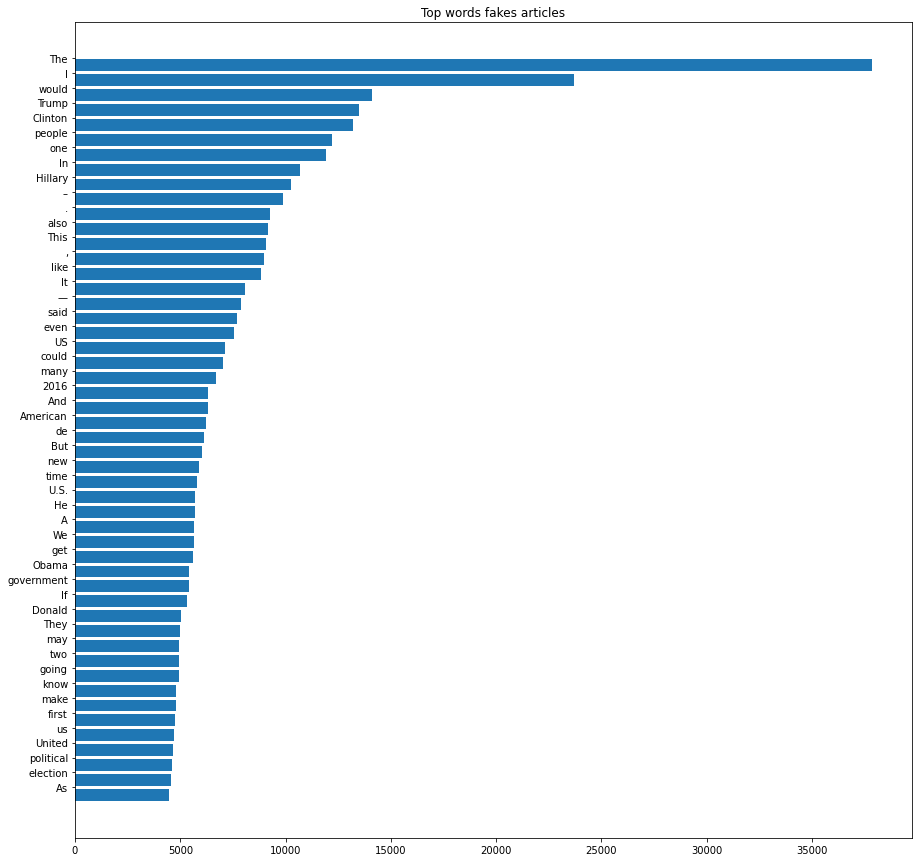

In [ ]:
plot_top_words(flat_list = flat_fakes_list, title = "Top words fakes articles") #They seem to mention a lot the emails thing from Hillary

# If I try to do a TfIdf it will run out of memory

There are about 40K articles. I will have a minimum of 10K words in my vocabulary. That alone is a matrix with 40K x 10K elements = 400 M. Even if it's stored as a sparse matrix, while creating it, it's dense at some point and it takes more than 16 GB memory.

The solution is word embeddings.